In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels as sm
import statsmodels.api as smt
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import os
import random
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
from keras_tuner import RandomSearch

In [4]:
data = pd.read_csv('UnderemploymentRate_InSample.csv')
test_data = pd.read_csv('UnderemploymentRate_OutofSample.csv')

data['Date']=pd.to_datetime(data['Date'],dayfirst=True)
data.set_index('Date', inplace=True)

test_data['Date']=pd.to_datetime(test_data['Date'],dayfirst=True)
test_data.set_index('Date', inplace=True)

data.head()

,Underemployment_Rate
Date,
1978-02-01,7.5
1978-03-01,6.6
1978-04-01,6.2
1978-05-01,6.2
1978-06-01,6.1


## Data processing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 479 entries, 1978-02-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Underemployment_Rate  479 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB


Text(0.5, 1.0, 'Boxplot of Underemployment Rate 1978-2017')

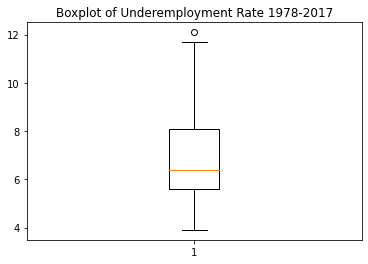

In [6]:
ts = data['Underemployment_Rate']
plt.boxplot(ts)
plt.title('Boxplot of Underemployment Rate 1978-2017')

In [7]:

# firstly define the outliners
Q1=np.percentile(ts,25,interpolation='midpoint')
Q2=np.percentile(ts,50,interpolation='midpoint')
Q3=np.percentile(ts,75,interpolation='midpoint')
IQR=Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR
outlier=[]

for x in ts:
    if((x>upper_limit)or(x<lower_limit)):
        outlier.append(x)

outlier

[12.1]

In [8]:
outlier_index=ts>upper_limit
data.loc[outlier_index].index
#data.drop(['1993-02-01'],inplace=True)
data['1993-02-01'] = np.median(data)



# EDA

## 1. Time Series Plot

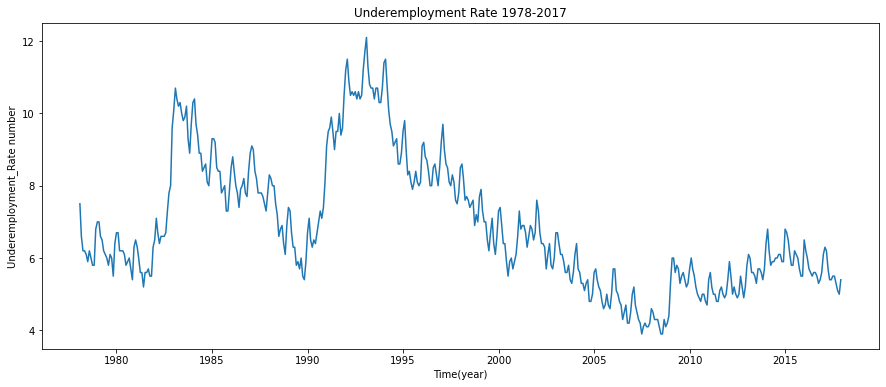

In [9]:
# plot
ts = data['Underemployment_Rate']
plt.figure(figsize = (15,6))
plt.plot(ts)
plt.title('Underemployment Rate 1978-2017')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.show()

## 2. check the seasonality & trend

In [10]:
ts = data['Underemployment_Rate']
data_CMA3 = ts.rolling(3,center=True).mean()
data_CMA4 = ts.rolling(4,center=True).mean().rolling(2,center=True).mean().shift(-1) #偶数shift-1
data_CMA12 = ts.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

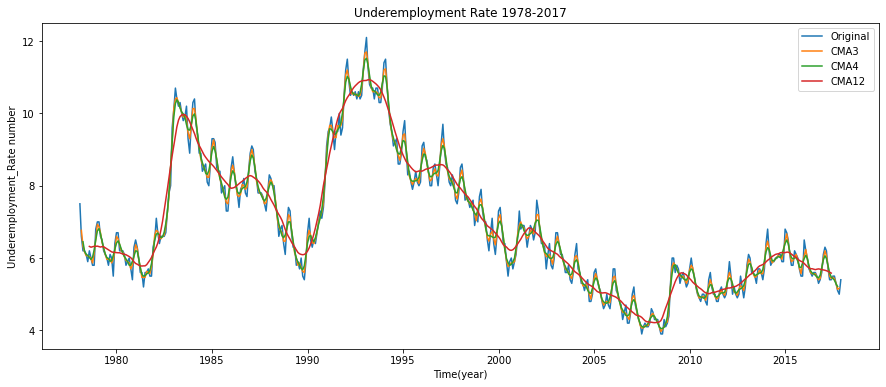

In [11]:
plt.figure(figsize = (15,6))
plt.plot(ts, label = 'Original')
plt.plot(data_CMA3, label = 'CMA3')
plt.plot(data_CMA4, label = 'CMA4')
plt.plot(data_CMA12, label = 'CMA12')
plt.title('Underemployment Rate 1978-2017')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.legend()
plt.show()

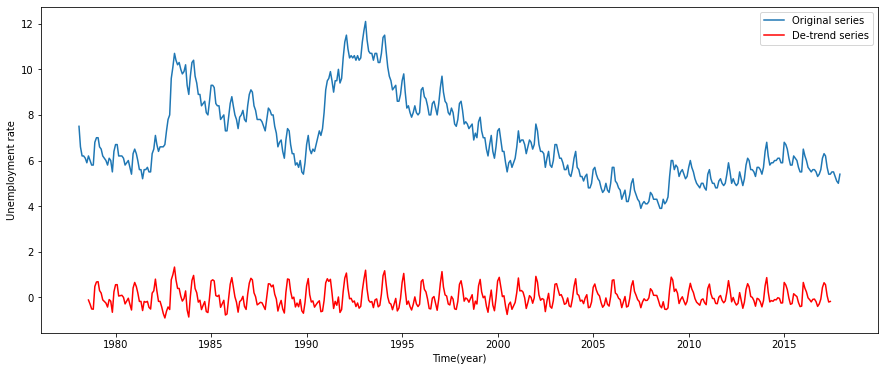

In [12]:
#detrend plot, indicate the addtive decomposition model
data_detrend = ts - data_CMA12

plt.figure(figsize = (15,6))
plt.plot(ts,label="Original series")
plt.plot(data_detrend,'r-',label="De-trend series")
plt.xlabel('Time(year)')
plt.ylabel('Unemployment rate')
plt.legend()

plt.show()

## 3. ACF and PACF

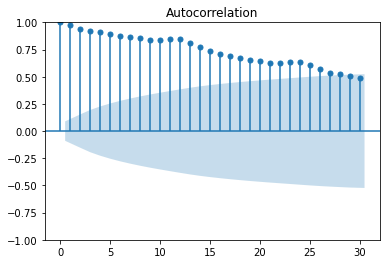

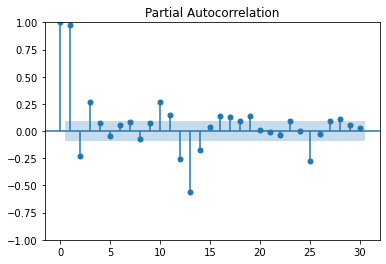

In [13]:
import statsmodels.api as smt

smt.graphics.tsa.plot_acf(ts, lags = 30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(ts, lags = 30, alpha = 0.05)

plt.show()

## 4. Differencing and ACF/PACF after diff

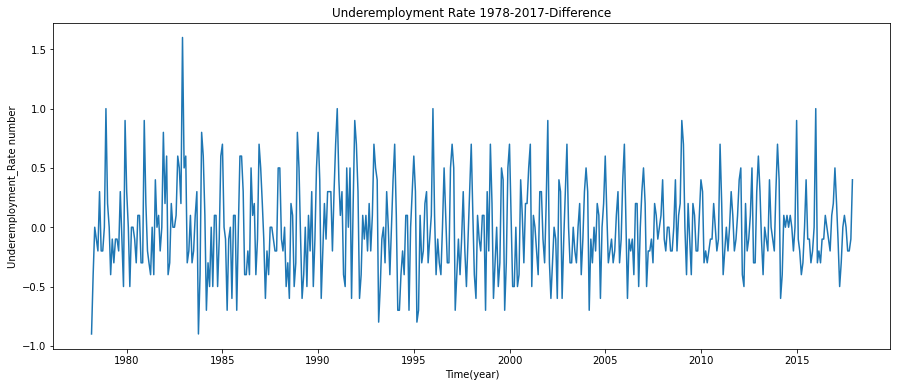

In [14]:
# do the difference
data_diff = pd.Series.diff(ts)
plt.figure(figsize = (15,6))
plt.plot(data_diff, label = 'Differenced')
plt.title('Underemployment Rate 1978-2017-Difference')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.show()

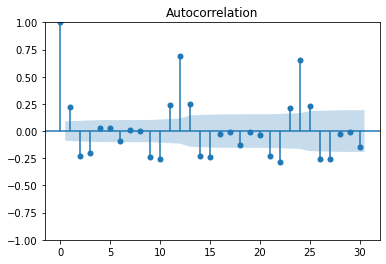

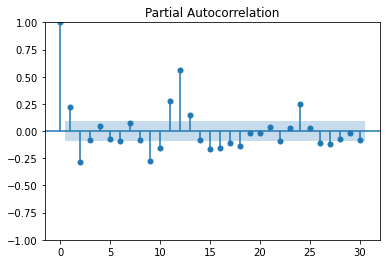

In [15]:
# ACF and PACF
smt.graphics.tsa.plot_acf(data_diff.dropna(), lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(data_diff.dropna(), lags=30, alpha = 0.05)
plt.show()

# more stationary, but shows significant seasonality

# 2. Model

## Split data set

In [16]:
ts_train = ts[:-24]
ts_valid = ts[-24:]

ts_train

Date
1978-02-01    7.5
1978-03-01    6.6
1978-04-01    6.2
1978-05-01    6.2
1978-06-01    6.1
             ... 
2015-08-01    6.1
2015-09-01    6.0
2015-10-01    5.7
2015-11-01    5.5
2015-12-01    5.5
Name: Underemployment_Rate, Length: 455, dtype: float64

## Moving Average

            Underemployment_Rate  Pred_one_step_MA3
Date                                               
2016-01-01                   6.5           6.058333
2016-02-01                   6.2           6.033333
2016-03-01                   6.0           5.991667
2016-04-01                   5.7           5.950000
2016-05-01                   5.6           5.916667
2016-06-01                   5.5           5.900000
2016-07-01                   5.6           5.875000
2016-08-01                   5.6           5.825000
2016-09-01                   5.5           5.783333
2016-10-01                   5.3           5.741667
2016-11-01                   5.4           5.708333
2016-12-01                   5.6           5.700000
2017-01-01                   6.1           5.708333
2017-02-01                   6.3           5.675000
2017-03-01                   6.2           5.683333
2017-04-01                   5.7           5.700000
2017-05-01                   5.4           5.700000
2017-06-01  

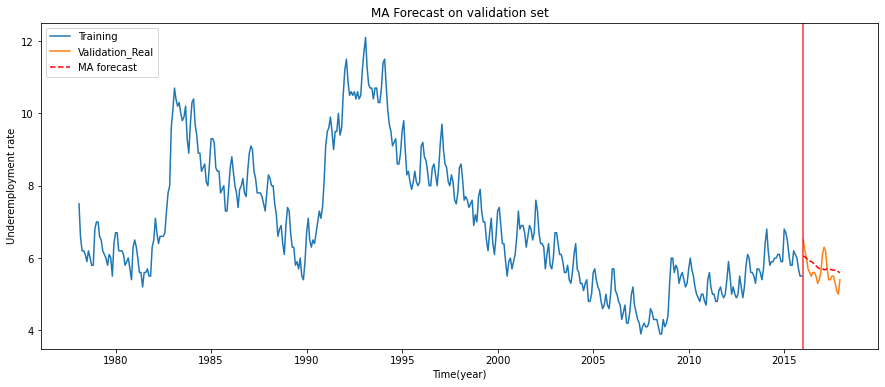

In [17]:
T_out = len(ts_valid)
# Get the MA-3 series and then extract corresponding smoothed values to make one-step-ahead forecast
ts_rolling = ts.rolling(12).mean()
ts_one_step_MA = ts_rolling[-T_out-1:-1].to_numpy()

# It is useful to put true and forecast for out-out-sample data in the same DataFrame
MA_forecast = pd.DataFrame(ts_valid)
MA_forecast['Pred_one_step_MA3'] = ts_one_step_MA
print(MA_forecast)

# Then plot the original and forecast data
plt.figure(figsize=(15,6))

plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'Validation_Real',)
plt.plot(ts_valid.index,MA_forecast['Pred_one_step_MA3'], '--r' , label = 'MA forecast')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)

plt.title('MA Forecast on validation set')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment rate')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error as mse
MA_mse = mse(ts_valid, MA_forecast['Pred_one_step_MA3'])
MA_rmse = MA_mse**0.5

print('RMSE for moving average is', MA_rmse.round(4))

RMSE for moving average is 0.3501


## Additive Decomposition

In [19]:
CMA12 = ts_train.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)
detrend = ts_train - CMA12
detrend

Date
1978-02-01   NaN
1978-03-01   NaN
1978-04-01   NaN
1978-05-01   NaN
1978-06-01   NaN
              ..
2015-08-01   NaN
2015-09-01   NaN
2015-10-01   NaN
2015-11-01   NaN
2015-12-01   NaN
Name: Underemployment_Rate, Length: 455, dtype: float64

In [20]:
detrend.shape

(455,)

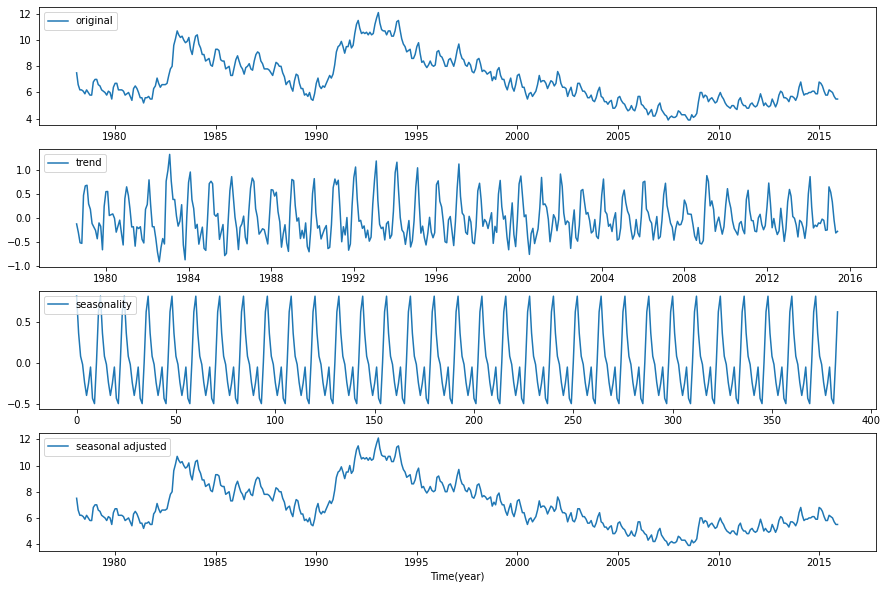

In [21]:
# Replace missing values in the ts_res by zeros
ts_res_zero = np.nan_to_num(detrend)

# Reshape the de-trended series to a table.
# A column contains data in a particular month of 12 years.
# For example, column 1 contains number of passengers in January of 12 years.

rows = ts_res_zero.size // 12

ts_res_zero = ts_res_zero[:rows * 12]

monthly_S = np.reshape(ts_res_zero,(rows,12))

# Calculate column averages (Average number of passengers in 12 months of 12 years)
monthly_avg = np.mean(monthly_S[1:31, :], axis=0)

# Normalize the seasonal index
seasonal_idx = monthly_avg.mean()
seasonal_idx_normalized = monthly_avg - seasonal_idx

# Seasonal component
seasonal = np.tile(seasonal_idx_normalized, 32)
seasonally_adjusted = ts_train - seasonal_idx

# Plot the seasonally adjusted data:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
ax[0].plot(ts_train)
ax[1].plot(detrend)
ax[2].plot(seasonal)
ax[3].plot(seasonally_adjusted)
ax[0].legend(['original'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)
plt.xlabel('Time(year)')
plt.show()

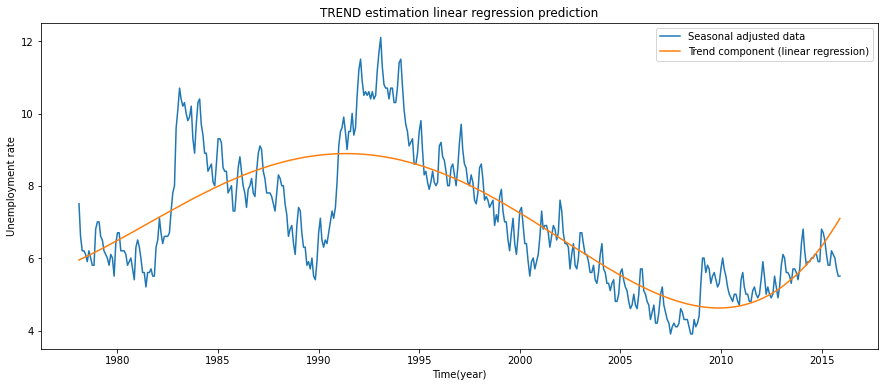

In [22]:
# Import library for quicky performing linear regression
from sklearn.linear_model import LinearRegression

# Prepare training data
X = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted), 1))
X = np.hstack((X, X**2, X**3, X**4))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted.values

# Create a LinearRegression object
lm = LinearRegression()

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

# Obtain estimation for the trend using the trained linear model
X_fitting = np.reshape(np.arange(1,len(seasonally_adjusted)+1), (len(seasonally_adjusted),1))
X_fitting = np.hstack((X_fitting, X_fitting**2, X_fitting**3, X_fitting**4))
trend_linear = lm.predict(X_fitting)

# Now plot the seasonally adjusted data and the corresponding regression line
plt.figure(figsize=(15,6))
plt.plot(ts_train.index,seasonally_adjusted)
plt.plot(ts_train.index,trend_linear)
plt.title('TREND estimation linear regression prediction')
plt.xlabel('Time(year)')
plt.ylabel('Unemployment rate')
plt.legend(['Seasonal adjusted data','Trend component (linear regression)'])
plt.show()

In [23]:
import numpy as np

# 创建验证时间序列
t_valid = np.arange(len(ts_train) + 1, len(ts_train) + 25).reshape(-1, 1)
T_valid = np.hstack((t_valid, t_valid**2, t_valid**3, t_valid**4))

# 趋势成分预测
Trend_forecast = lm.predict(T_valid)

# 季节成分预测
Seasonal_forecast = np.tile(seasonal_idx_normalized, 2)

# 组合预测
decomposition_forecast = Trend_forecast + Seasonal_forecast
decomposition_forecast


array([ 7.99293589,  7.62233548,  7.42243115,  7.40726351,  7.27128987,
        7.2003565 ,  7.43572635,  7.72449576,  7.43473335,  7.46297998,
        8.06216545,  8.77341407,  9.06285016,  8.71145923,  8.53092125,
        8.53527736,  8.41898541,  8.36789217,  8.62326114,  8.93218918,
        8.66274543,  8.71147129,  9.33129708, 10.06334764])

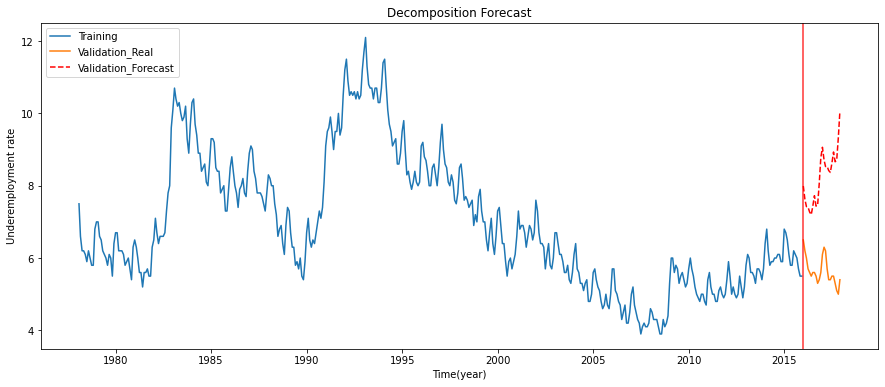

In [24]:
plt.figure(figsize=(15,6))
plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'Validation_Real',)
plt.plot(ts_valid.index,decomposition_forecast, '--r' , label = 'Validation_Forecast')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)

plt.title('Decomposition Forecast')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment rate')
plt.legend()
plt.show()

In [25]:
decomposition_mse = mse(ts_valid, decomposition_forecast)
decomposition_rmse = decomposition_mse**0.5

print('RMSE for Additive Decomposition is', decomposition_rmse.round(4))

RMSE for Additive Decomposition is 2.7441


## Trend corrected exponential smoothing





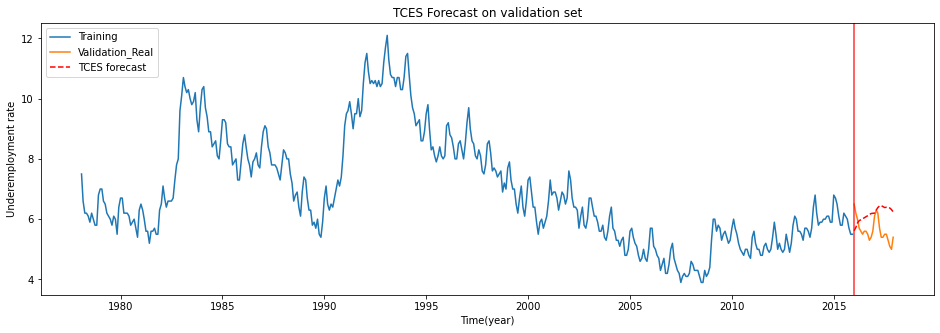

In [26]:
# Set a small value for alpha and beta
alpha = 0.1
beta = 0.1

# Assign initial values for level and trend
l0 = ts_train[0]
b0 = ts_train[1] - ts_train[0]

# Initialize the smoothed, level and trend series by copying the visitors series(pre-allocation)
# By doing this, we imply that l0 is set to be the first value of the visitors series
y_forecast = ts_train.copy().astype(float)
lt = ts_train.copy().astype(float)
bt = ts_train.copy().astype(float)

# Compute l[1], b[1] and Y_hat[2]
lt[0] = alpha * ts_train[0] + (1 - alpha) * (l0 + b0)
bt[0] = beta * (lt[0] - l0) + (1 - beta) * b0
y_forecast[1] = lt[0] + bt[0]

# Create a loop to compute the forecast values using TCES
for t in range(1,len(ts_train)-1):

    # Compute level component
    lt[t] = alpha * ts_train[t] + (1 - alpha) * (lt[t-1] + bt[t-1])

    # Compute trend component
    bt[t] = beta * (lt[t] - lt[t-1]) + (1 - beta) * bt[t-1]

    # Get the one-step-ahead forecast values
    y_forecast[t+1] = lt[t] + bt[t]

T_out = len(ts_valid)
# Extract one-step-ahead forecast values for out-of-sample data
TCES_forecast = y_forecast[-T_out:]

# Ploting the smoothing and forecast results
plt.figure(figsize=(16,5))
plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'Validation_Real',)
plt.plot(ts_valid.index,TCES_forecast, '--r' , label = 'TCES forecast')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)

plt.title('TCES Forecast on validation set')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment rate')
plt.legend()
plt.show()


In [27]:
TCES_mse = mse(ts_valid, TCES_forecast)
TCES_rmse = TCES_mse**0.5

print('RMSE for trend corrected exponential smoothing is', decomposition_rmse.round(4))

RMSE for trend corrected exponential smoothing is 2.7441


## Holt Winters Additive

In [28]:
# choose additive
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_add = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add',
                               seasonal='add').fit() # Holt-Winters additive smoothing

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
# show the results
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])

params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

results["Additive"] = [hw_add.params[p] for p in params] + [hw_add.sse]
print(results.round(4))

          Additive
$\alpha$    0.8579
$\beta$     0.0000
$\gamma$    0.1421
$l_0$       6.5529
$b_0$      -0.0016
SSE        23.9565


In [30]:
print(hw_add.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:     Underemployment_Rate   No. Observations:                  455
Model:             ExponentialSmoothing   SSE                             23.956
Optimized:                         True   AIC                          -1307.546
Trend:                         Additive   BIC                          -1241.622
Seasonal:                      Additive   AICC                         -1305.978
Seasonal Periods:                    12   Date:                 Thu, 23 May 2024
Box-Cox:                          False   Time:                         23:21:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8579053                alpha                 True
smoothing_trend          

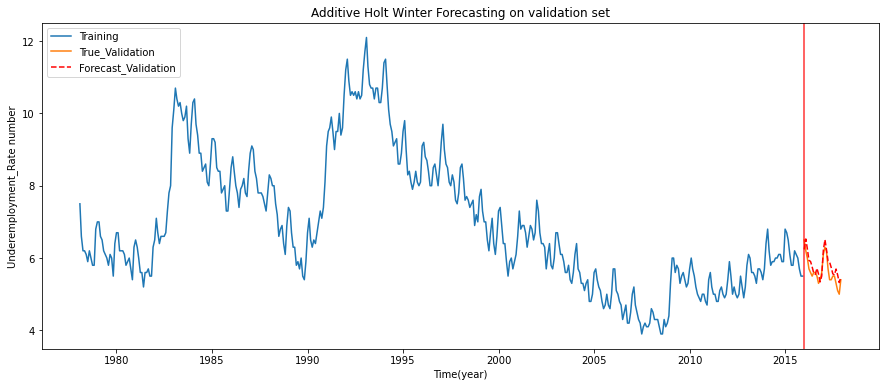

In [31]:
y_forecast_hwadd = hw_add.forecast(24)

# show the plot
plt.figure(figsize = (15,6))
plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'True_Validation')
plt.plot(y_forecast_hwadd, '--r', label = 'Forecast_Validation')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)
plt.title('Additive Holt Winter Forecasting on validation set')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.legend()
plt.show()

In [32]:
# rmse

from sklearn.metrics import mean_squared_error as mse

hw_mse = mse(ts_valid, y_forecast_hwadd)
hw_rmse = hw_mse**0.5

print('RMSE for Additive Holt Winters is', hw_rmse.round(4))

RMSE for Additive Holt Winters is 0.2501


## ARIMA

In [33]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

data_diff = data_diff.dropna()

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('Stationary (Reject Null Hypothesis)')
    else:
        print('Non-Stationary (Fail to Reject Null Hypothesis)')


check_stationarity(data_diff.dropna())

ADF Statistic: -5.614152313113331
p-value: 1.184877159391705e-06
Stationary (Reject Null Hypothesis)


In [34]:
from pmdarima import auto_arima

# split data after first order differencing
train_diff = ts_train.diff().dropna()
valid_diff = ts_valid.diff().dropna()

model_arima = auto_arima(train_diff, start_p=0, start_q=0, max_p=3, max_q=3,
                    seasonal=False, trace=True, suppress_warnings=True)

# Print the summary of the best model selected by auto_arima
print(model_arima.summary())

# Forecast future values using the best model
forecast_arima = model_arima.predict(n_periods=len(valid_diff))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=418.719, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=397.653, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=381.525, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=380.723, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=359.410, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=359.244, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=358.993, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=360.152, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=360.933, Time=0.28 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.793 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  454
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -175.496
Date:                Thu, 23 May 2024   AIC               

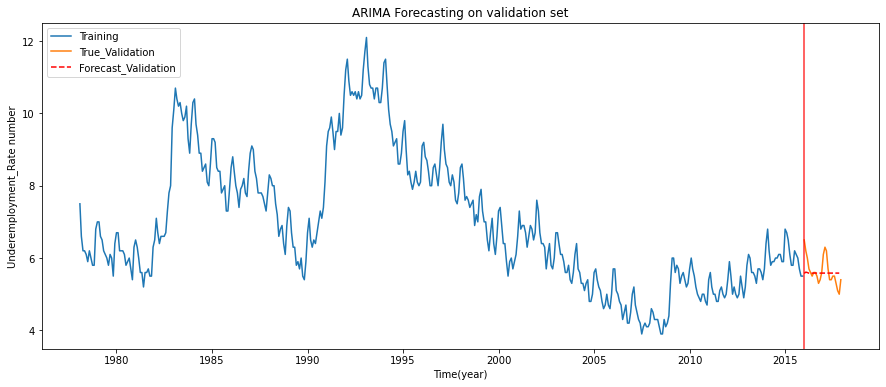

In [35]:
# show the plot
forecast_cumsum = np.cumsum(forecast_arima)

original_forecast = forecast_cumsum + ts_train.iloc[-1]

plt.figure(figsize = (15,6))
plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'True_Validation')
plt.plot(original_forecast, 'r--', label = 'Forecast_Validation')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)
plt.title('ARIMA Forecasting on validation set')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.legend()
plt.show()

In [36]:
arima_mse = mse(ts_valid[:-1], original_forecast)
arima_rmse = arima_mse**0.5

print('RMSE for ARIMA(2,0,3) is', arima_rmse.round(4))

RMSE for ARIMA(2,0,3) is 0.3854


## Seasonal ARIMA

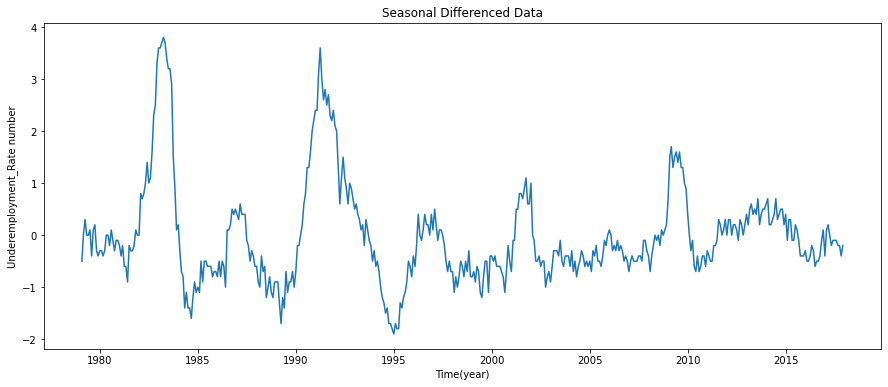

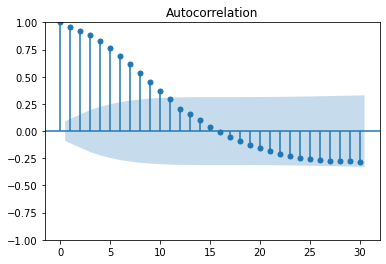

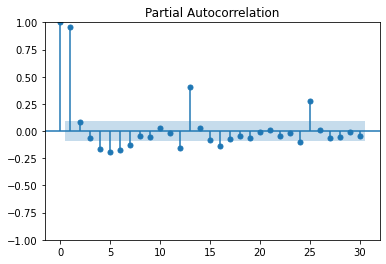

ADF Statistic: -4.449959567554171
p-value: 0.00024189588291159567
Stationary (Reject Null Hypothesis)


In [37]:
diff_12 = ts - ts.shift(12)
diff_12 = diff_12.dropna()

plt.figure(figsize = (15,6))
plt.plot(diff_12)
plt.title("Seasonal Differenced Data")
plt.ylabel('Underemployment_Rate number')
plt.xlabel('Time(year)')
plt.show()

# ACF and PACF for seasonal difference
smt.graphics.tsa.plot_acf(diff_12.dropna(), lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(diff_12.dropna(), lags=30, alpha = 0.05)
plt.show()

check_stationarity(diff_12)

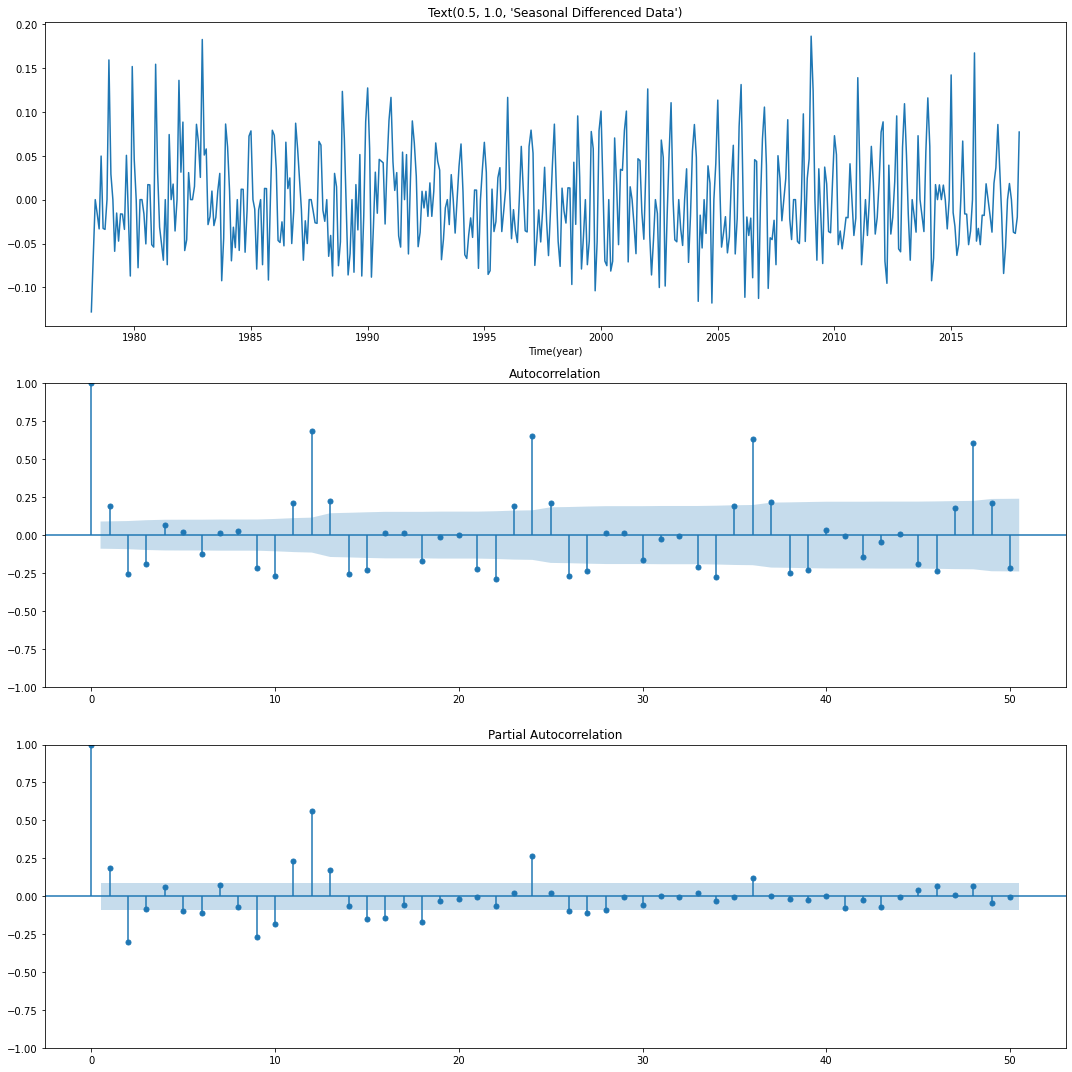

In [38]:
ts_log = np.log(ts)

ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# Plot the 1st-differencing series
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Plot the time series
axs[0].plot(ts_log_diff)
axs[0].set_title(plt.title("Seasonal Differenced Data"))
axs[0].set_xlabel('Time(year)')

# Plot sample ACF
smt.graphics.tsa.plot_acf(ts_log_diff, lags=50, alpha=0.05, ax=axs[1])

# Plot sample PACF
smt.graphics.tsa.plot_pacf(ts_log_diff, lags=50, alpha=0.05, ax=axs[2])

plt.tight_layout()
plt.show()

In [39]:
check_stationarity(ts_log_diff)

ADF Statistic: -5.574391099443455
p-value: 1.443160862442891e-06
Stationary (Reject Null Hypothesis)


In [40]:
ts_log_train = ts_log_diff[:-24]
ts_log_valid = ts_log_diff[-24:]

model_sarima = auto_arima(ts_log_train, start_p=0, start_q=0, max_p=3, max_q=3,
                   seasonal=True, m=12, trace=True, suppress_warnings=True)

print(model_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1768.904, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1330.650, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1625.108, Time=0.86 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1483.941, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1332.582, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1482.375, Time=0.33 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1625.139, Time=0.31 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-1767.348, Time=1.81 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-1763.826, Time=1.92 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-1552.469, Time=1.40 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-1698.875, Time=0.96 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=-1765.005, Time=2.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-1763.400, Time=0.98 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-1769.962, Time=1.99 sec
 ARIM

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit the model to obtain rmse
model_sarima = SARIMAX(ts_train,
                order = (3,0,1),                 # Non-seasonal component
                seasonal_order = (2,0,1,12),     # Seasonal component
                trend = 'c', # Intercept
                enforce_stationarity = False,
                enforce_invertibility = False)

n_periods = 24
model_sarima_fit = model_sarima.fit()
forecast_sarima = model_sarima_fit.forecast(steps = n_periods)

rmse_sarima = np.sqrt(mse(ts_valid, forecast_sarima))
print('Validation RMSE for Seasonal ARIMA is', rmse_sarima.round(4))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Validation RMSE for Seasonal ARIMA is 0.338


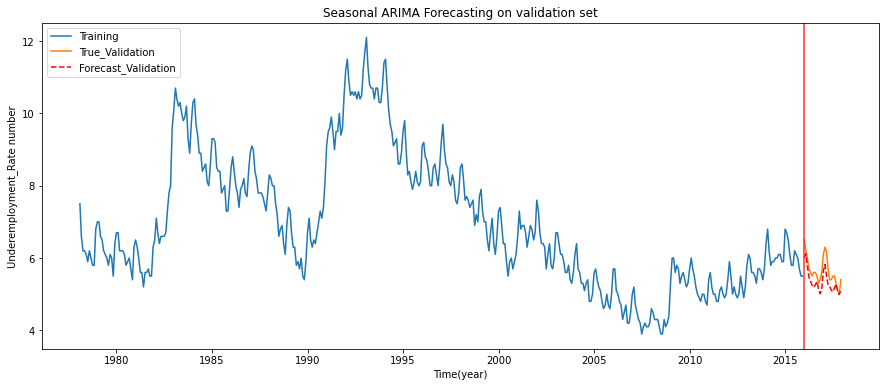

In [42]:
plt.figure(figsize = (15,6))
plt.plot(ts_train, label = 'Training')
plt.plot(ts_valid, label = 'True_Validation')
plt.plot(forecast_sarima, 'r--', label = 'Forecast_Validation')
plt.axvline(x = ts.index[len(ts_train)], color = 'red', alpha = 0.8)
plt.title('Seasonal ARIMA Forecasting on validation set')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.legend()
plt.show()

## Neural Networks

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [44]:
# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ts_train = scaler.fit_transform(ts_train.values.reshape(-1, 1))
scaled_ts_valid = scaler.transform(ts_valid.values.reshape(-1, 1))

# Create the dataset
def create_dataset(data, time_window=12):
    X, Y = [], []
    for i in range(len(data) - time_window):
        X.append(data[i:(i + time_window), 0])
        Y.append(data[i + time_window, 0])
    return np.array(X), np.array(Y)

time_window = 12
X_train, Y_train = create_dataset(scaled_ts_train, time_window)

# Start the creation of the validation set using the data from the last time_window of the training set
extended_ts_valid = np.concatenate((scaled_ts_train[-time_window:], scaled_ts_valid), axis=0)
X_valid, Y_valid = create_dataset(extended_ts_valid, time_window)

# Ensure the shape is correct
X_train = X_train.reshape((X_train.shape[0], time_window))
X_valid = X_valid.reshape((X_valid.shape[0], time_window))

# Train and evaluate the neural network model
def create_model(hidden_layers, neurons, activation):
    model = Sequential()
    model.add(Input(shape=(time_window,)))
    for i in range(hidden_layers):
        model.add(Dense(neurons[i], activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the hyperparameter grid
hidden_layer_options = [1, 2, 3]
neuron_options = [[32], [64], [128], [64, 32], [128, 64], [128, 64, 32]]
activation_options = ['relu', 'tanh']
epochs = 100
batch_size = 20

best_rmse = float('inf')
best_model = None
best_params = None

# Grid search
for hidden_layers in hidden_layer_options:
    for neurons in neuron_options:
        if len(neurons) < hidden_layers:
            continue
        for activation in activation_options:
            model = create_model(hidden_layers, neurons, activation)
            early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
            model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                      validation_data=(X_valid, Y_valid), callbacks=[early_stop])
            valid_predict = model.predict(X_valid)
            valid_predict = scaler.inverse_transform(valid_predict).reshape(-1)
            Y_valid_actual = scaler.inverse_transform(Y_valid.reshape(-1, 1)).reshape(-1)
            valid_rmse = np.sqrt(mean_squared_error(Y_valid_actual, valid_predict))

            print(f'Hidden Layers: {hidden_layers}, Neurons: {neurons}, Activation: {activation}, Validation RMSE: {valid_rmse:.4f}')

            if valid_rmse < best_rmse:
                best_rmse = valid_rmse
                best_model = model
                best_params = (hidden_layers, neurons, activation)



#  Evaluate the best model
train_predict = best_model.predict(X_train)
valid_predict = best_model.predict(X_valid)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
valid_predict = scaler.inverse_transform(valid_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_valid_actual = scaler.inverse_transform(Y_valid.reshape(-1, 1))


Epoch 1/100
23/23 [==============================] - 1s 13ms/step - loss: 0.0369 - val_loss: 0.0089
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0026
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 11

In [45]:
model.summary()

# Calculate RMSE
train_rmse_nn = np.sqrt(mean_squared_error(Y_train_actual, train_predict))
valid_rmse_nn = np.sqrt(mean_squared_error(Y_valid_actual, valid_predict))

print(f'Best Model Params: Hidden Layers: {best_params[0]}, Neurons: {best_params[1]}, Activation: {best_params[2]}')
print(f'Best Validation RMSE: {best_rmse:.4f}')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 128)               1664      
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________
Best Model Params: Hidden Layers: 1, Neurons: [128, 64], Activation: relu
Best Validation RMSE: 0.2223


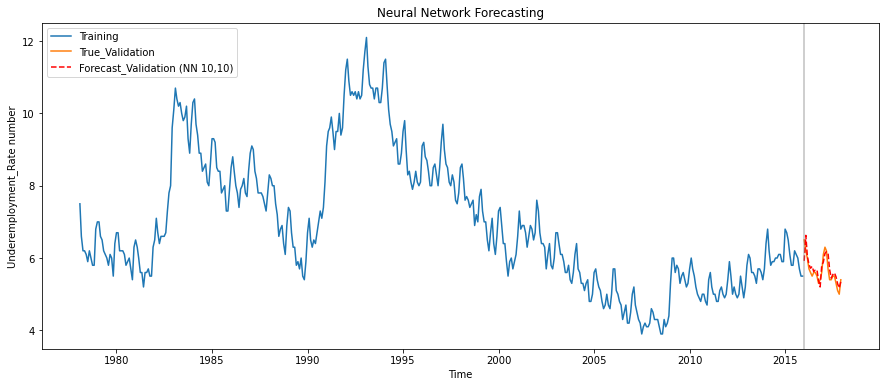

In [46]:
# Plot the results for Neural Network
plt.figure(figsize=(15,6))
plt.plot(ts_train, label='Training')
plt.plot(ts_valid, label='True_Validation')
plt.plot(ts_valid.index, valid_predict[-len(ts_valid):], '--r', label='Forecast_Validation (NN 10,10)')
plt.axvline(x=ts_valid.index[0], color='grey', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Underemployment_Rate number')
plt.title('Neural Network Forecasting')
plt.legend()
plt.show()

## Recurrent NN

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_50 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
80/80 [==============================] - 2s 9ms/step - loss: 0.0793 - val_loss: 0.0125
Epoch 2/300
80/80 [==============================] - 1s 7ms/step - loss: 0.0236 - val_loss: 0.0093
Epoch 3/300
80/80 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0080
Epoch 4/300
80/80 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0076
Epoch 5/300
80/80 [==============================] - 0s 5

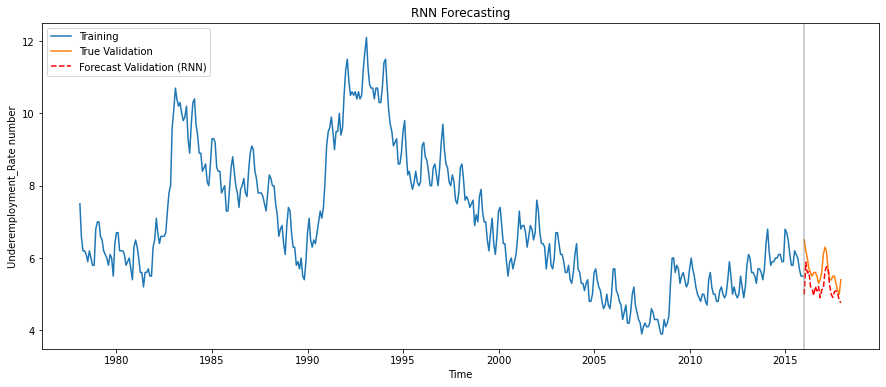

In [47]:
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Create the dataset function
def create_dataset(data, time_window=12):
    X, Y = [], []
    for i in range(len(data) - time_window):
        X.append(data[i:(i + time_window), 0])
        Y.append(data[i + time_window, 0])
    return np.array(X), np.array(Y)

# Time window to define the number of features in each row
time_window = 12

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ts_train = scaler.fit_transform(ts_train.values.reshape(-1, 1))
scaled_ts_valid = scaler.transform(ts_valid.values.reshape(-1, 1))

# Create datasets
X_train, Y_train = create_dataset(scaled_ts_train, time_window)

# Extend the validation set using the end of the training set
extended_ts_valid = np.concatenate((scaled_ts_train[-time_window:], scaled_ts_valid), axis=0)
X_valid, Y_valid = create_dataset(extended_ts_valid, time_window)

# Reshape for RNN input
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_rnn = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

# Define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=8, input_shape=(time_window, 1)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the RNN model
history_rnn = model_rnn.fit(X_train_rnn, Y_train, epochs=300, batch_size=5, validation_split=0.1, shuffle=False, callbacks=[early_stop])

# Predict validation set
valid_predict_rnn = model_rnn.predict(X_valid_rnn)

# Inverse transform predictions
valid_predict_rnn_inv = scaler.inverse_transform(valid_predict_rnn).reshape(-1)
Y_valid_inv = scaler.inverse_transform(Y_valid.reshape(-1, 1)).reshape(-1)

# Calculate RMSE for validation set
rnn_rmse = np.sqrt(mean_squared_error(Y_valid_inv, valid_predict_rnn_inv))
print(f'Validation RMSE (RNN): {rnn_rmse:.4f}')

# Plot the results for RNN
plt.figure(figsize=(15, 6))
plt.plot(ts_train.index, scaler.inverse_transform(scaled_ts_train), label='Training')
plt.plot(ts_valid.index, scaler.inverse_transform(scaled_ts_valid), label='True Validation')
plt.plot(ts_valid.index, valid_predict_rnn_inv, '--r', label='Forecast Validation (RNN)')
plt.axvline(x=ts_valid.index[0], color='grey', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Underemployment_Rate number')
plt.title('RNN Forecasting')
plt.legend()
plt.show()

## Long-Short Term Memory

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
80/80 [==============================] - 4s 16ms/step - loss: 0.0479 - val_loss: 0.0033
Epoch 2/300
80/80 [==============================] - 1s 11ms/step - loss: 0.0189 - val_loss: 0.0021
Epoch 3/300
80/80 [==============================] - 1s 10ms/step - loss: 0.0137 - val_loss: 0.0021
Epoch 4/300
80/80 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0024
Epoch 5/300
80/80 [==============================] 

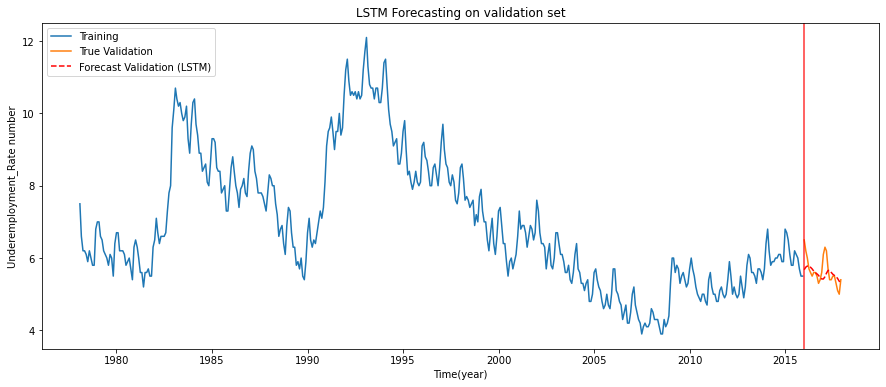

In [48]:
from tensorflow.keras.layers import LSTM

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=8, input_shape=(time_window, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the LSTM model
history_lstm = model_lstm.fit(X_train_rnn, Y_train, epochs=300, batch_size=5, validation_split=0.1, shuffle=False, callbacks=[early_stop])

# Predict validation set
valid_predict_lstm = model_lstm.predict(X_valid_rnn)

# Inverse transform predictions
valid_predict_lstm_inv = scaler.inverse_transform(valid_predict_lstm).reshape(-1)
Y_valid_inv = scaler.inverse_transform(Y_valid.reshape(-1, 1)).reshape(-1)

# Calculate RMSE for validation set
lstm_rmse = np.sqrt(mean_squared_error(Y_valid_inv, valid_predict_lstm_inv))
print(f'Validation RMSE (LSTM): {lstm_rmse:.4f}')

# Plot the results for LSTM
plt.figure(figsize=(15, 6))
plt.plot(ts_train.index, scaler.inverse_transform(scaled_ts_train), label='Training')
plt.plot(ts_valid.index, scaler.inverse_transform(scaled_ts_valid), label='True Validation')
plt.plot(ts_valid.index, valid_predict_lstm_inv, '--r', label='Forecast Validation (LSTM)')
plt.axvline(x=ts_valid.index[0], color='red', alpha=0.8)
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.title('LSTM Forecasting on validation set')
plt.legend()
plt.show()

## Random Forest

Validation RMSE (Random Forest): 0.1433


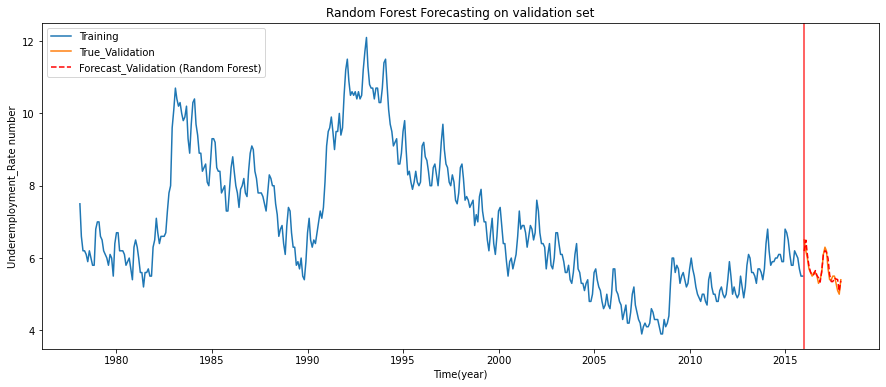

In [49]:
# Create the dataset
X_train_rf, Y_train_rf = create_dataset(scaled_ts_train, time_window)
X_valid_rf, Y_valid_rf = create_dataset(extended_ts_valid, time_window)

# Ensure the shape is correct
X_train_rf = X_train_rf.reshape((X_train_rf.shape[0], time_window))
X_valid_rf = X_valid_rf.reshape((X_valid_rf.shape[0], time_window))

# Train and evaluate the random forest model
def train_and_evaluate_rf():
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X_train_rf, Y_train_rf)

    valid_predict_rf = rf_model.predict(X_valid_rf)

    valid_predict_rf = scaler.inverse_transform(valid_predict_rf.reshape(-1, 1)).reshape(-1)
    Y_valid_actual_rf = scaler.inverse_transform(Y_valid_rf.reshape(-1, 1)).reshape(-1)

    valid_rmse_rf = np.sqrt(mean_squared_error(Y_valid_actual_rf, valid_predict_rf))

    return valid_rmse_rf, valid_predict_rf

# Train and evaluate
valid_rmse_rf, valid_predict_rf = train_and_evaluate_rf()
print(f'Validation RMSE (Random Forest): {valid_rmse_rf:.4f}')

# Plot the results for Random Forest
plt.figure(figsize=(15,6))
plt.plot(ts_train, label='Training')
plt.plot(ts_valid, label='True_Validation')
plt.plot(ts_valid.index, valid_predict_rf[-len(ts_valid):], '--r', label='Forecast_Validation (Random Forest)')
plt.axvline(x=ts_valid.index[0], color='red', alpha=0.8)
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.title('Random Forest Forecasting on validation set')
plt.legend()
plt.show()

## Gradient Boosting

Validation RMSE (Gradient Boosting): 0.1640


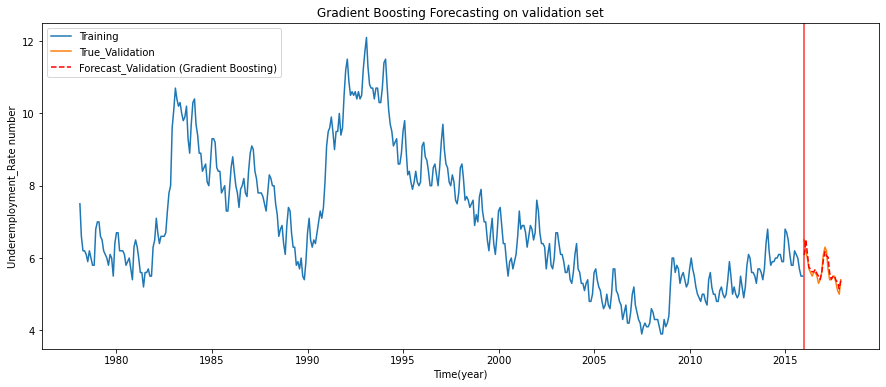

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

# Ensure the shape is correct
X_train_gb = X_train.reshape((X_train.shape[0], time_window))
X_valid_gb = X_valid.reshape((X_valid.shape[0], time_window))

# Train and evaluate the Gradient Boosting model
def train_and_evaluate_gb(n_estimators=100, learning_rate=0.1):
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    model.fit(X_train_gb, Y_train)

    valid_predict = model.predict(X_valid_gb)
    valid_predict = scaler.inverse_transform(valid_predict.reshape(-1, 1)).reshape(-1)
    Y_valid_actual = scaler.inverse_transform(Y_valid.reshape(-1, 1)).reshape(-1)

    valid_rmse = np.sqrt(mean_squared_error(Y_valid_actual, valid_predict))
    return valid_rmse, valid_predict

# Train and evaluate
valid_rmse_gb, valid_predict_gb = train_and_evaluate_gb()
print(f'Validation RMSE (Gradient Boosting): {valid_rmse_gb:.4f}')

# Plot the results for Gradient Boosting
plt.figure(figsize=(15,6))
plt.plot(ts_train, label='Training')
plt.plot(ts_valid, label='True_Validation')
plt.plot(ts_valid.index, valid_predict_gb[-len(ts_valid):], '--r', label='Forecast_Validation (Gradient Boosting)')
plt.axvline(x=ts_valid.index[0], color='red', alpha=0.8)
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate number')
plt.title('Gradient Boosting Forecasting on validation set')
plt.legend()
plt.show()

## Transformer

In [51]:
# Set the random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [52]:
ts = data['Underemployment_Rate']
df_train = ts[:-34]
df_vali = ts[-34:] # we set the sequence size to be 10, which means that we use the firts 10 data to predict the next value,
                   # so 34-10 = 24, that's why we set the size of the validation set to be 34

scaler = StandardScaler() # data normalization
df_train = scaler.fit_transform(df_train.values.reshape(-1, 1)).flatten()
df_vali = scaler.transform(df_vali.values.reshape(-1, 1)).flatten()

spots_train = df_train.tolist()
spots_vali = df_vali.tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Validation set has {} observations.".format(len(spots_vali)))

Training set has 445 observations.
Validation set has 34 observations.


> **Citation**: The following code snippet is sourced from the GitHub repository by Jeff Heaton:
> [GitHub Repository - T81_558: Deep Learning](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb)

In [53]:
def to_sequences(seq_size, obs):
    x = []
    y = []

# This fucntion splits the data into x and y variables, after the x sequence, the next value will be y, the one we want to predict
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

# We use this function to form a time-series neural network

SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_vali, y_vali = to_sequences(SEQUENCE_SIZE, spots_vali)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of validation set: {}".format(x_vali.shape))

Shape of training set: (435, 10, 1)
Shape of validation set: (24, 10, 1)


In [54]:
# the code in this chunk creates a transformer_encoder, the layer in it will normalize and set the attention for the model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization, Multi-head Attention and dropout
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x) # prevent overfitting
    res = x + inputs

# The feed forward part controls the size of the hidden layers in the feed-forward network
    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [55]:
# In this section we build the model and create the attention layer
def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(hp.Int('num_transformer_blocks', 2, 6, step=1)):
        x = transformer_encoder(
            x,
            head_size=hp.Choice('head_size', [64, 128, 256]),
            num_heads=hp.Choice('num_heads', [2, 4, 8]),
            ff_dim=hp.Choice('ff_dim', [4, 16, 32]),
            dropout=hp.Choice('dropout', [0.1, 0.2, 0.3])
        )

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        x = layers.Dense(hp.Int(f'unit_{i}', min_value=64, max_value=256, step=64), activation='relu')(x)
        x = layers.Dropout(hp.Float('mlp_dropout', 0.1, 0.5, step=0.1))(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2]))
    )
    return model

> **Citation**: The following code snippet for using `keras-tuner` was generated with the assistance of ChatGPT, an AI model developed by OpenAI.


In [56]:
import shutil

# Clear previous checkpoints to avoid conflicts
#shutil.rmtree('my_dir', ignore_errors=True)

input_shape = x_train.shape[1:]

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Here we implement the keras-tuner package to help with the selection of the most optimal hyperparameter
tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Train the best model found by the tuner
history = best_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

# Evaluate the best model on the validation set
evaluation = best_model.evaluate(x_vali, y_vali, verbose=1)
print(f"Validation loss: {evaluation}")

Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Search space summary
Default search space size: 11
num_transformer_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
head_size (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
num_heads (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 8], 'ordered': True}
ff_dim (Choice)
{'default': 4, 'conditions': [], 'values': [4, 16, 32], 'ordered': True}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
unit_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
mlp_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'def

In [57]:
# Predict on the validation set with the best model
pred = best_model.predict(x_vali)
score = np.sqrt(metrics.mean_squared_error(pred, y_vali))
print("Score (RMSE): {}".format(score))

1/1 [==============================] - 1s 715ms/step
Score (RMSE): 0.15489336994391414


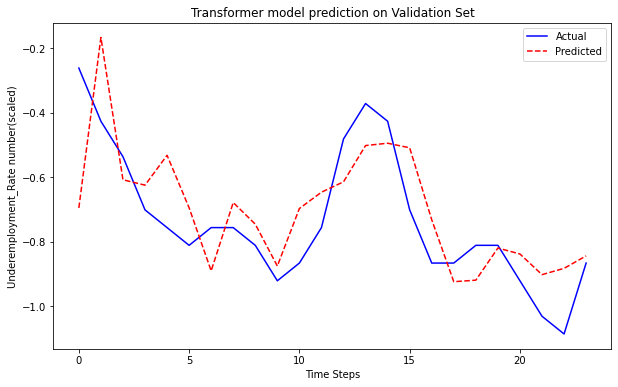

In [58]:
# Plot the actual vs predicted values for the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_vali, label='Actual', color='blue')
plt.plot(pred, label='Predicted', color='red', linestyle='dashed')
plt.title('Transformer model prediction on Validation Set')
plt.xlabel('Time Steps')
plt.ylabel('Underemployment_Rate number(scaled)')
plt.legend()
plt.show()

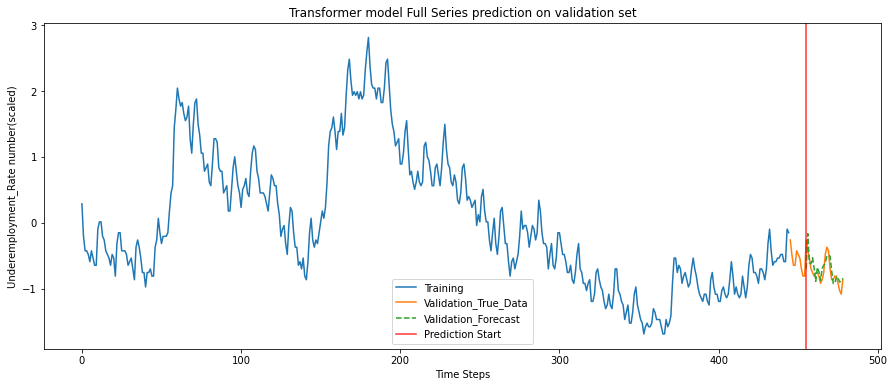

In [59]:
# Plot the full series with training, validation, and predicted values
start_index = SEQUENCE_SIZE  # The first prediction is after 10 steps in validation set

plt.figure(figsize=(15, 6))
plt.plot(range(len(df_train)), df_train, label='Training')
plt.plot(range(len(df_train), len(df_train) + len(df_vali)), df_vali, label='Validation_True_Data')
plt.plot(range(len(df_train) + start_index, len(df_train) + start_index + len(pred)), pred, label='Validation_Forecast', linestyle='dashed')
plt.axvline(x=len(df_train) + start_index, color='red', label='Prediction Start', alpha = 0.8)
plt.title('Transformer model Full Series prediction on validation set')
plt.xlabel('Time Steps')
plt.ylabel('Underemployment_Rate number(scaled)')
plt.legend()
plt.show()

## Conlusion

In [60]:
model_selection = [['Model Name','Validation RMSE'],
             ['Moving Average', MA_rmse],
               ['Addictive Decomposition', decomposition_rmse],
               ['Trend Corrected Exponential Smoothing', TCES_rmse],
               ['Holt Winters Additive', hw_rmse],
                   ['ARIMA', arima_rmse],
                   ['Seasonal ARIMA', rmse_sarima],
                   ['Neural Network', valid_rmse_nn],
                   ['Recurrent NN',rnn_rmse],
                   ['Long-Short Term Memory',lstm_rmse],
                   ['Random Forest', valid_rmse_rf],
                   ['Gradient Boosting', valid_rmse_gb],
                   ['Transformer', score]
                   ]
from operator import itemgetter

# Sort the model_selection list by Validation RMSE (assuming Validation RMSE is the second column)
sorted_model_selection = sorted(model_selection[1:], key=itemgetter(1), reverse=False)

# Add the header row back to the sorted list
sorted_model_selection.insert(0, model_selection[0])

# Print the sorted model selection
print(tabulate(sorted_model_selection, headers='firstrow', tablefmt='fancy_grid', floatfmt='.4f', numalign='center', stralign='center'))

╒═══════════════════════════════════════╤═══════════════════╕
│              Model Name               │  Validation RMSE  │
╞═══════════════════════════════════════╪═══════════════════╡
│             Random Forest             │      0.1433       │
├───────────────────────────────────────┼───────────────────┤
│              Transformer              │      0.1549       │
├───────────────────────────────────────┼───────────────────┤
│           Gradient Boosting           │      0.1640       │
├───────────────────────────────────────┼───────────────────┤
│            Neural Network             │      0.2223       │
├───────────────────────────────────────┼───────────────────┤
│         Holt Winters Additive         │      0.2501       │
├───────────────────────────────────────┼───────────────────┤
│            Seasonal ARIMA             │      0.3380       │
├───────────────────────────────────────┼───────────────────┤
│            Moving Average             │      0.3501       │
├───────

# 4. Test

In [61]:
ts_tv = ts
ts_test = test_data['Underemployment_Rate']

## Seasonal ARIMA

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(ts,
                order = (3,0,1),                 # Non-seasonal component
                seasonal_order = (2,0,1,12),     # Seasonal component
                trend = 'c', # Intercept
                enforce_stationarity = False,
                enforce_invertibility = False)

n_periods = 24
model_sarima_fit = model_sarima.fit()
forecast_sarima = model_sarima_fit.forecast(steps = n_periods)

test_sarima_rmse = np.sqrt(mse(ts_test, forecast_sarima))
print('Test RMSE for Seasonal ARIMA(3,0,1)(2,0,1) is', test_sarima_rmse.round(4))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE for Seasonal ARIMA(3,0,1)(2,0,1) is 0.3413


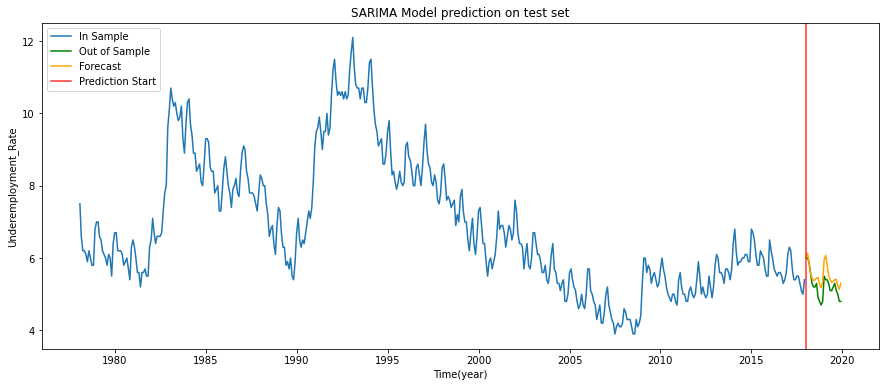

In [63]:
combined_ts = pd.concat([ts, ts_test])

# Plot the combined time series data
plt.figure(figsize=(15, 6))
# in sample
plt.plot(combined_ts.index[:len(ts)], combined_ts[:len(ts)], label='In Sample', linestyle='-')
# out of sample
plt.plot(combined_ts.index[len(ts):], combined_ts[len(ts):], label='Out of Sample', color='green', linestyle='-')
plt.plot(test_data.index, forecast_sarima, color='orange', label='Forecast')
plt.axvline(x = combined_ts.index[len(ts)], color='red', alpha = 0.8, label='Prediction Start')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate')
plt.title('SARIMA Model prediction on test set')
plt.legend()
plt.show()

## Neural Networks

In [64]:
# Prepare the test data
extended_ts_test = np.concatenate((scaled_ts_train[-time_window:], scaler.transform(ts_test.values.reshape(-1, 1))), axis=0)
X_test, Y_test = create_dataset(extended_ts_test, time_window)

# Ensure the shape is correct
X_test = X_test.reshape((X_test.shape[0], time_window))

# Predict with the trained model on test data
test_predict_nn = model.predict(X_test)

# Inverse transform the predictions and the actual test values
test_predict_nn = scaler.inverse_transform(test_predict_nn).reshape(-1)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1)).reshape(-1)

# Calculate RMSE for the test data
test_rmse_nn = np.sqrt(mean_squared_error(Y_test_actual, test_predict_nn))
print(f'Test RMSE for Neural Network: {test_rmse_nn:.4f}')

1/1 [==============================] - 0s 64ms/step
Test RMSE for Neural Network: 0.4102


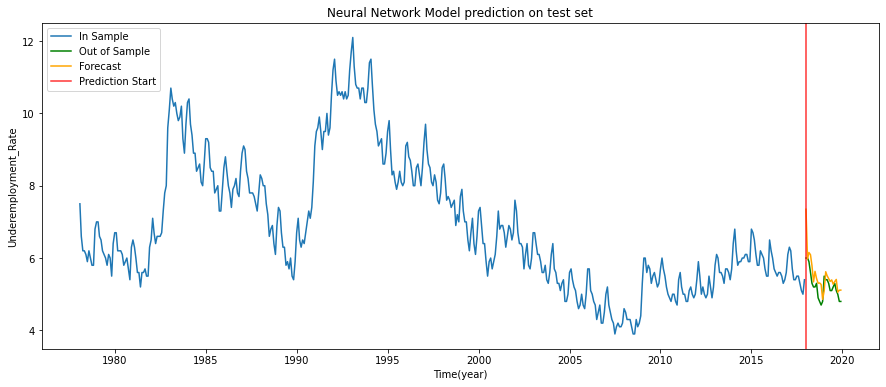

In [65]:
# Plot the results for Neural Network
combined_ts = pd.concat([ts, ts_test])

plt.figure(figsize=(15, 6))
plt.plot(combined_ts.index[:len(ts)], combined_ts[:len(ts)], label='In Sample', linestyle='-')
plt.plot(combined_ts.index[len(ts):], combined_ts[len(ts):], label='Out of Sample', color='green', linestyle='-')
plt.plot(test_data.index, test_predict_nn, color='orange', label='Forecast')
plt.axvline(x=combined_ts.index[len(ts)], color='red', alpha=0.8, label='Prediction Start')
plt.xlabel('Time(year)')
plt.ylabel('Underemployment_Rate')
plt.title('Neural Network Model prediction on test set')
plt.legend()
plt.show()

## **Transformer**

In [66]:
test_data = pd.read_csv('UnderemploymentRate_OutofSample.csv')
ts_test = test_data['Underemployment_Rate']
ts_test.head(5)

0    6.0
1    6.0
2    5.9
3    5.6
4    5.3
Name: Underemployment_Rate, dtype: float64

> **Citation**: The following code snippet for performing the test set prediction was generated with the assistance of ChatGPT, an AI model developed by OpenAI.


In [67]:
# Combine training and validation sets
combined_spots = spots_train + spots_vali

# Transform combined dataset to sequences
SEQUENCE_SIZE = 10
x_combined, y_combined = to_sequences(SEQUENCE_SIZE, combined_spots)

# Load and normalize the test data
test_data = pd.read_csv('UnderemploymentRate_OutofSample.csv')
ts_test = test_data['Underemployment_Rate']

ts_last_10 = ts[-10:]
ts_test = pd.concat([ts_last_10.reset_index(drop=True), ts_test.reset_index(drop=True)], ignore_index=True)


# Normalize the test data using the same scaler
ts_test_normalized = scaler.transform(ts_test.values.reshape(-1, 1)).flatten()

# Transform test data to sequences
x_test, y_test = to_sequences(SEQUENCE_SIZE, ts_test_normalized.tolist())

# Retrain the best model on the combined dataset
best_model.fit(
    x_combined,
    y_combined,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

# Predict on the test data
test_predictions = best_model.predict(x_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
print("Test RMSE: {}".format(test_rmse))

# Print the first few predictions for inspection
print("First few predictions: ", test_predictions[:5])
print("First few actual values: ", y_test[:5])

Epoch 1/200
6/6 [==============================] - 1s 170ms/step - loss: 0.0291 - val_loss: 0.0213
Epoch 2/200
6/6 [==============================] - 1s 170ms/step - loss: 0.0304 - val_loss: 0.0206
Epoch 3/200
6/6 [==============================] - 1s 170ms/step - loss: 0.0289 - val_loss: 0.0223
Epoch 4/200
6/6 [==============================] - 1s 154ms/step - loss: 0.0286 - val_loss: 0.0202
Epoch 5/200
6/6 [==============================] - 1s 170ms/step - loss: 0.0321 - val_loss: 0.0213
Epoch 6/200
6/6 [==============================] - 1s 168ms/step - loss: 0.0292 - val_loss: 0.0210
Epoch 7/200
6/6 [==============================] - 1s 169ms/step - loss: 0.0265 - val_loss: 0.0194
Epoch 8/200
6/6 [==============================] - 1s 164ms/step - loss: 0.0269 - val_loss: 0.0196
Epoch 9/200
6/6 [==============================] - 1s 207ms/step - loss: 0.0258 - val_loss: 0.0237
Epoch 10/200
6/6 [==============================] - 1s 158ms/step - loss: 0.0276 - val_loss: 0.0228
Epoch 11/

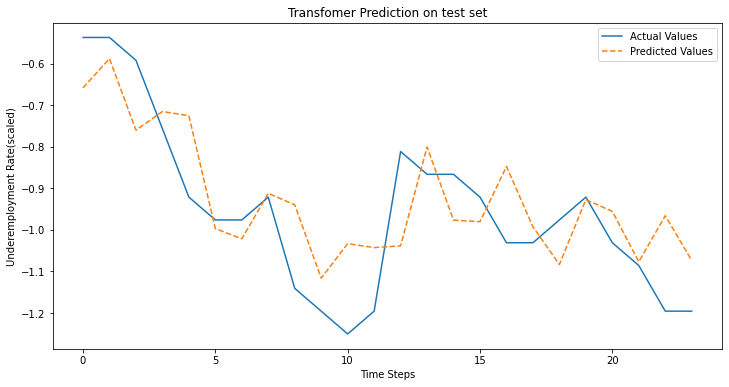

In [68]:
# Plotting the predictions against the actual values
plt.figure(figsize=(12, 6))

plt.plot(y_test, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='--')

plt.title('Transfomer Prediction on test set')
plt.xlabel('Time Steps')
plt.ylabel('Underemployment Rate(scaled)')
plt.legend()
plt.show()

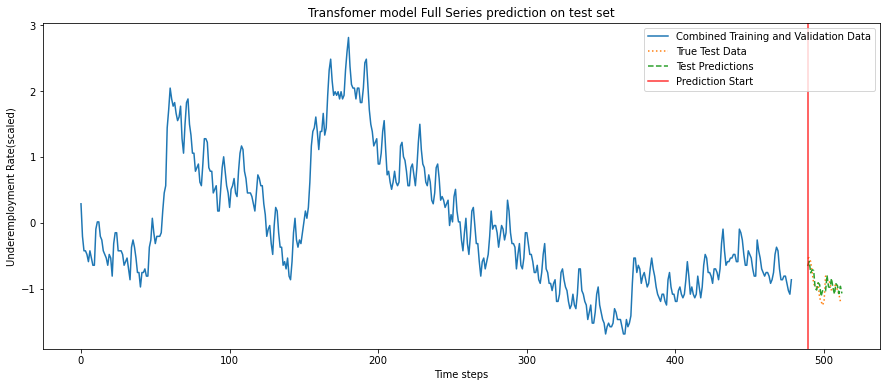

In [69]:
# Plot the full series with training, validation, and predicted values
plt.figure(figsize=(15, 6))

# Plot combined training and validation data
combined_data = np.concatenate([df_train, df_vali])
plt.plot(range(len(combined_data)), combined_data, label='Combined Training and Validation Data')

# Plot true test data
test_data_length = len(y_test)
plt.plot(range(len(combined_data) + SEQUENCE_SIZE, len(combined_data) + SEQUENCE_SIZE + test_data_length), y_test, label='True Test Data', linestyle='dotted')

# Plot test predictions
plt.plot(range(len(combined_data) + SEQUENCE_SIZE, len(combined_data) + SEQUENCE_SIZE + test_data_length), test_predictions, label='Test Predictions', linestyle='dashed')

plt.axvline(x=len(combined_data) + SEQUENCE_SIZE, color='red', alpha = 0.8, label='Prediction Start')

plt.title('Transfomer model Full Series prediction on test set')
plt.xlabel('Time steps')
plt.ylabel('Underemployment Rate(scaled)')
plt.legend()
plt.show()

## Test Conclusion

In [70]:
final_model = [
                  ['Seasonal ARIMA', test_sarima_rmse],
                   ['Neural Network', test_rmse_nn],
                   ['Transformer', test_rmse]
                   ]

# Sort the model_selection list by Validation RMSE
final_model = sorted(final_model[0:], key=itemgetter(1), reverse=False)

header = ['Model Name','Test RMSE']

# Print the sorted model selection
print(tabulate(final_model, headers=header, tablefmt='fancy_grid', floatfmt='.4f', numalign='center', stralign='center'))

╒════════════════╤═════════════╕
│   Model Name   │  Test RMSE  │
╞════════════════╪═════════════╡
│  Transformer   │   0.1288    │
├────────────────┼─────────────┤
│ Seasonal ARIMA │   0.3413    │
├────────────────┼─────────────┤
│ Neural Network │   0.4102    │
╘════════════════╧═════════════╛
